## Initial notebook for project 

In [1]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO

## Path to dir with data (remember the last '/')
path = "../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

In [2]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

eeg = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {eeg.shape[0]}  -  nchannels: {eeg.shape[1]}  -  t: {eeg.shape[2]}")

nsamples: 5184  -  nchannels: 22  -  t: 800


In [3]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples, nchannels, t = eeg.shape  

labels = torch.tensor(metadata["value"].values, dtype=torch.long)

train_dataset = TensorDataset(eeg, labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

adj_matrix = torch.eye(nchannels)  #place holder change later FIX

In [4]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConv, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x, adj):
        x = torch.matmul(adj, x)  
        x = torch.matmul(x, self.weight) + self.bias  
        return torch.relu(x)

class EEG_GNN(nn.Module):
    def __init__(self, in_features, hidden_dim, nclasses, nchannels):
        super(EEG_GNN, self).__init__()
        self.conv1 = GraphConv(in_features, hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(nchannels) 
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(nchannels) 
        self.conv3 = GraphConv(hidden_dim, nclasses)  

    def forward(self, x, adj):
        x = self.conv1(x, adj)
        x = self.batch_norm1(x)  
        x = F.relu(x)
        x = self.conv2(x, adj)
        x = self.batch_norm2(x)  
        x = F.relu(x)
        x = self.conv3(x, adj)  
        x = x.mean(dim=1)  
        return x

In [5]:
print(adj_matrix.shape)
print(type(adj_matrix))
print(nsamples)

torch.Size([22, 22])
<class 'torch.Tensor'>
5184


In [6]:
# Compute Pearson correlation between channels
threshold = 0.5  # Keep only strong correlations
tmp_lst=[]
for i in range(nsamples): 
    correlation_matrix = np.corrcoef(eeg[i])
    tmp_lst.append((correlation_matrix > threshold).astype(np.float32))
# Convert correlation to adjacency matrix
adj_matrix2 = torch.from_numpy(np.array(tmp_lst))

In [7]:
print(adj_matrix.shape)
print(type(adj_matrix))

torch.Size([22, 22])
<class 'torch.Tensor'>


In [ ]:

class TrainGNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, adjacency_matrix, learning_rate=0.0005, epochs=500):
        model = model.to(self.device)
        adjacency_matrix = adjacency_matrix.to(self.device)  # Move adjacency to GPU if available

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        highest_train_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs, adjacency_matrix)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            #acclist[epoch]=epoch_accuracy
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        print(f"Highest Trained Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), 'eeg_gnn.pth')

        return model

In [ ]:
nclasses = labels.max().item() + 1 
model = EEG_GNN(in_features=t, hidden_dim=32, nclasses=nclasses, nchannels=nchannels)

trainer = TrainGNN()
trained_model = trainer.train_model(model, train_loader, adj_matrix,epochs=200)

Epoch 1/200, Loss: 1.9628, Accuracy: 23.40%
Epoch 2/200, Loss: 1.7679, Accuracy: 24.17%
Epoch 3/200, Loss: 1.6883, Accuracy: 24.52%
Epoch 4/200, Loss: 1.6465, Accuracy: 24.86%
Epoch 5/200, Loss: 1.6255, Accuracy: 24.54%
Epoch 6/200, Loss: 1.6123, Accuracy: 24.98%
Epoch 7/200, Loss: 1.6034, Accuracy: 25.10%
Epoch 8/200, Loss: 1.5961, Accuracy: 25.50%
Epoch 9/200, Loss: 1.5902, Accuracy: 25.77%
Epoch 10/200, Loss: 1.5851, Accuracy: 25.98%
Epoch 11/200, Loss: 1.5795, Accuracy: 26.50%
Epoch 12/200, Loss: 1.5756, Accuracy: 27.35%
Epoch 13/200, Loss: 1.5701, Accuracy: 27.41%
Epoch 14/200, Loss: 1.5649, Accuracy: 27.78%
Epoch 15/200, Loss: 1.5598, Accuracy: 28.28%
Epoch 16/200, Loss: 1.5552, Accuracy: 28.55%
Epoch 17/200, Loss: 1.5496, Accuracy: 28.88%
Epoch 18/200, Loss: 1.5443, Accuracy: 29.53%
Epoch 19/200, Loss: 1.5388, Accuracy: 29.88%
Epoch 20/200, Loss: 1.5333, Accuracy: 30.29%
Epoch 21/200, Loss: 1.5265, Accuracy: 30.73%
Epoch 22/200, Loss: 1.5209, Accuracy: 30.94%
Epoch 23/200, Loss:

In [ ]:

def multirunmodel(trainer,paramlist,nruns=10):
    '''
    Runs a models with the same hyperparameters but random training parameters

    ...
    
    Parameters
    ------------------
    trainer: TrainGNN
         training class for the model 
    paramlist : list
        list of all the parametors needed for the model
    nruns : int 
        How many runs it makes, default 10
    '''    
    modellist = [0 for x in range(nruns)]
    trainingdata = [0 for x in range(nruns)]
    for i in range(nruns):
        modellist[i],trainingdata[i] =  trainer.train_model(model, paramlist[0], paramlist[1],epochs=paramlist[2])
    

    # plot
    fig, axs = plt.subplots(2, nruns//2, layout='constrained')

    for i in range(nruns//2):
        ax=axs[0][i]
        ax.plot(np.arange(0, 1e6, 1000))
        ax.set_title(f'Modelrun {i+nruns//2}')


        ax = axs[1][i]
        for j in range(len(trainingdata[i+nruns//2])):
                ax.plot(trainingdata[i+nruns//2])
        ax.plot()
        ax.plot(np.arange(0, 1e6, 1000))
        ax.set_title(f'Modelrun {i+nruns//2}')
    plt.show()

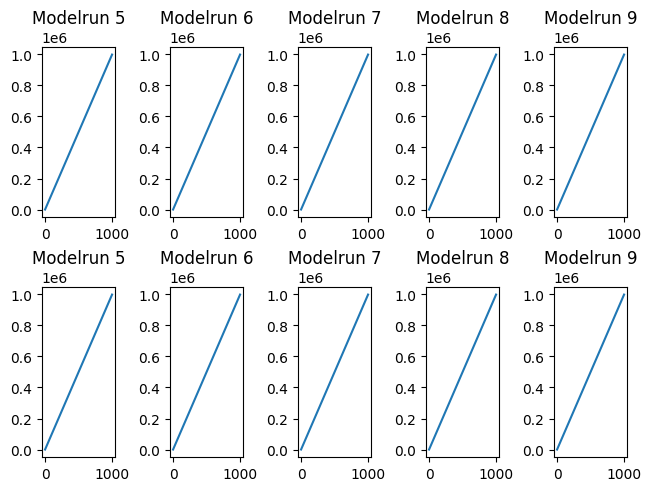

In [18]:
fig, axs = plt.subplots(2, 10//2, layout='constrained')

for i in range(10//2):
        ax=axs[0][i]
        ax.plot(np.arange(0, 1e6, 1000))
        ax.set_title(f'Modelrun {i+10//2}')


        ax = axs[1][i]
        ax.plot(np.arange(0, 1e6, 1000))

        ax.set_title(f'Modelrun {i+10//2}')
plt.show()

In [27]:
a = [[1, 2], [1], ["a"]]
print(a[0][1])  # Output: 2



2
